### Imports

In [23]:
%load_ext autoreload
%autoreload 2

import random

import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from data_utils import *
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from graph_vae.vae import GraphVAE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Model & Dataset

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# models trained with LUMO property prediction and various KL weights
# checkpoint = "./checkpoints/graph_vae_20240605_161349.pt"  # kl_weight=1.0
# checkpoint = "./checkpoints/graph_vae_20240605_173849.pt"  # kl_weight=0.1
# checkpoint = "./checkpoints/graph_vae_20240605_190517.pt"  # kl_weight=0.05
# checkpoint = "./checkpoints/graph_vae_20240605_205034.pt"  # kl_weight=0.02
checkpoint = "./checkpoints/graph_vae_20240605_221712.pt"  # kl_weight=0.01

model = GraphVAE.from_pretrained(checkpoint_path=checkpoint).to(device)
model.eval()

# property names used in the plots of this notebook
property_to_name_map = {
    "lumo": "LUMO (eV)",
    "homo": "HOMO (eV)",
    "r2": r"R2 ($\AA^2$)"
}
property_name = property_to_name_map[model.properties[0]]

include_hydrogen = False
prop_norm_df = create_or_load_property_norm_df()

# create dataset and dataloaders
dataset = create_qm9_graph_vae_dataset(
    device=device, 
    include_hydrogen=False, 
    refresh_data_cache=False,
    properties=model.properties,
    prop_norm_df=prop_norm_df
)

_, val_dataset, _ = create_qm9_data_split(dataset=dataset)

batch_size = 1024
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

print(f"Validation set size = {len(val_dataset)}")

Validation set size = 12805


In [4]:
dataset_properties = list()
for batch in tqdm(full_loader, desc="Getting Dataset Property Distribution"):
    dataset_properties.append(model.denormalize_properties(batch.y))

Getting Dataset Property Distribution:   0%|          | 0/126 [00:00<?, ?it/s]

Getting Dataset Property Distribution: 100%|██████████| 126/126 [01:02<00:00,  2.00it/s]


### KDE of latent space after encoding validation set

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 128/128 [00:16<00:00,  7.61it/s]


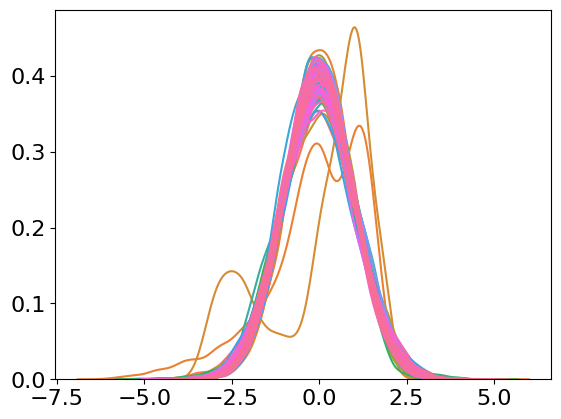

In [3]:
def plot_latent_kde(model: GraphVAE, val_loader: DataLoader):
    """ Plot a kernel density estimate of the distribution of ~5000 encoded validation molecules along each dimension of the latent space. """

    z_list = []
    num_molecules = 0
    for batch in tqdm(val_loader):
        with torch.no_grad():
            z = model.encode(batch)
        z_list.append(z)
        num_molecules += len(batch)

    z = torch.concat(z_list, dim=0).detach().cpu()

    latent_dim = model.latent_dim
    for dim in tqdm(range(z.shape[1])):
        sns.kdeplot(z[:, dim], legend=False, color=sns.color_palette("husl", latent_dim)[dim])
    
    # plt.title(f'KDE of each latent dimension (n={latent_dim})')
    plt.gca().set_ylabel('')
    plt.show()

plot_latent_kde(model=model, val_loader=val_loader)

### PCA

  0%|          | 0/126 [00:00<?, ?it/s]

100%|██████████| 126/126 [01:02<00:00,  2.01it/s]


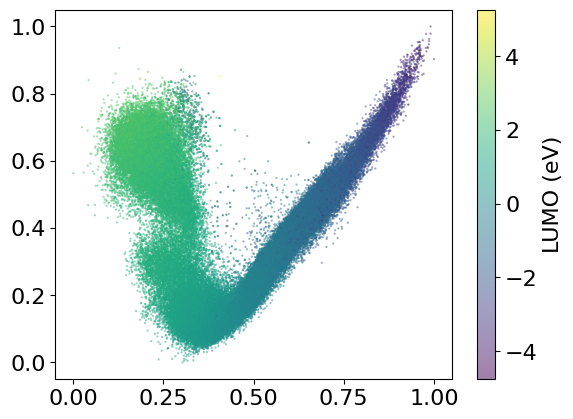

In [4]:
# encode dataset into latent space and plot PCA with points colored based on the molecule properties
def plot_dataset_latent_pca(model: GraphVAE, loader: DataLoader):
    z_list = []
    y_list = []
    for batch in tqdm(loader):
        with torch.no_grad():
            z_list.append(model.z_to_property_z(model.encode_mean(batch)))
            y_list.append(model.denormalize_properties(batch.y))

    z = torch.cat(z_list, dim=0).detach().cpu().numpy()
    y = torch.cat(y_list, dim=0).detach().cpu().numpy()

    z_pca = PCA(n_components=2).fit_transform(z)
    z_pca = MinMaxScaler().fit_transform(z_pca)

    scatter = plt.scatter(x= z_pca[:, 0], y=z_pca[:,1], c=y[:, 0],
                cmap= 'viridis', marker='.',
                s=10,alpha=0.5, edgecolors='none')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.colorbar(scatter, label=property_name)
    plt.show()

plot_dataset_latent_pca(model=model, loader=full_loader)

  0%|          | 0/126 [00:00<?, ?it/s]

100%|██████████| 126/126 [00:41<00:00,  3.01it/s]


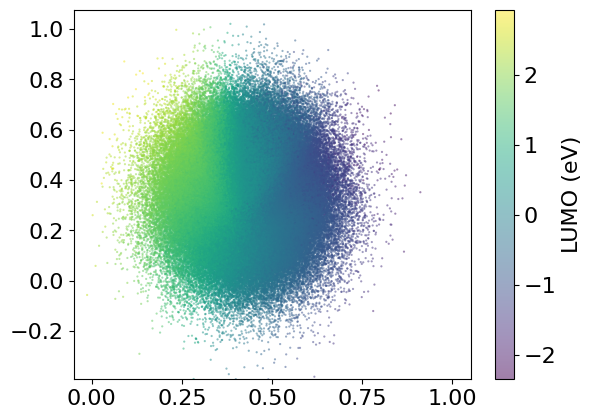

In [5]:
# plot PCA of random latent samples from prior with properties predicted by the model
# the principal components are computed based on the encoded dataset

def plot_sampled_latent_pca(model: GraphVAE, loader: DataLoader, device: str):
    z_dataset_list = []
    for batch in tqdm(loader):
        with torch.no_grad():
            z_dataset_list.append(model.z_to_property_z(model.encode_mean(batch)))

    z_dataset = torch.cat(z_dataset_list, dim=0).detach().cpu().numpy()
    pca_fitted = PCA(n_components=2).fit(z_dataset)
    z_pca_dataset = pca_fitted.transform(z_dataset)
    scaler_fitted = MinMaxScaler().fit(z_pca_dataset)

    z = torch.randn((200000, model.property_z_size), device=device)
    y = model.denormalize_properties(model.predict_properties(z)[0])

    z = z.detach().cpu().numpy()
    y = y.detach().cpu().numpy()

    z_pca = pca_fitted.transform(z)
    z_pca = scaler_fitted.transform(z_pca)

    scatter = plt.scatter(x= z_pca[:, 0], y=z_pca[:,1], c=y[:, 0],
                cmap= 'viridis', marker='.',
                s=10,alpha=0.5, edgecolors='none')
     
    plt.xlim(min(np.min(z_pca[:, 0]), -0.05), max(np.max(z_pca[:, 0]), 1.05))
    plt.ylim(min(np.min(z_pca[:, 1]), -0.05), max(np.max(z_pca[:, 1]), 1.05))
    plt.colorbar(scatter, label=property_name)
    plt.show()                                              

plot_sampled_latent_pca(model=model, loader=full_loader, device=device)

### Property Distribution

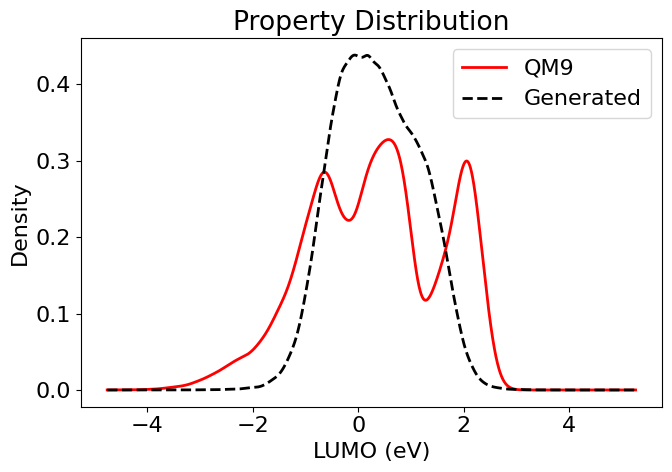

In [25]:
# Dataset property distribution
y_dataset = torch.cat(dataset_properties, dim=0)[:, 0].cpu().numpy()

z = torch.randn((200000, model.property_z_size), device=device)
y_pred_mu, y_pred_sigma = model.predict_properties(z=z)
y_sampled = model.denormalize_properties(y=torch.randn_like(y_pred_mu) * y_pred_sigma + y_pred_mu)[:, 0].detach().cpu().numpy()

min_value = np.min(y_dataset)
max_value = np.max(y_dataset)

_, ax = plt.subplots(figsize=(7, 5))
x_d = np.linspace(min_value, max_value, 2048)

ax.plot(x_d, gaussian_kde(y_dataset)(x_d), color='red', linewidth=2, label="QM9")
ax.plot(x_d, gaussian_kde(y_sampled)(x_d), "--", color='black', linewidth=2, label="Generated")

plt.xlabel(property_name)
plt.ylabel("Density")
plt.legend()
plt.title("Property Distribution")
plt.tight_layout()
plt.show()